# **🏦 EL PROBLEMA & ANÁLISIS DEL BANCO**

**📖 La Situación**

**Beta Bank pierde clientes cada mes.**

- Costo de adquisición: **$500 por cliente**
- Costo de retención: **$100 por cliente** (5x más barato)
- Pero sin predicción, es imposible actuar

**Pregunta:** ¿Quién se irá en los próximos meses?

## 🎯 Objetivo

Crear modelo con **F1 ≥ 0.59** que identifique clientes con riesgo de churn para campañas de retención.

## 🔧 Setup Inicial

In [21]:
# Importes esenciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(12345)

print("✅ Setup completado")

✅ Setup completado


## 📂 Cargar y Explorar Datos

In [23]:
# Cargar dataset
df = pd.read_csv('../data/raw/Churn.csv')

print(f"Dimensiones: {df.shape[0]:,} clientes × {df.shape[1]} features")
print(f"\nPrimeras filas:")
display(df.head())

Dimensiones: 10,000 clientes × 14 features

Primeras filas:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [24]:
# Información del dataset
print("Información:")
display(df.info())
print(f"\nValores ausentes:\n{df.isnull().sum()}")

Información:
<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  str    
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  str    
 5   Gender           10000 non-null  str    
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), str(3)
memory usage: 1.1 MB


None


Valores ausentes:
RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64


## 📊 Análisis Exploratorio (EDA)

In [25]:
# Estadísticas básicas
print("Estadísticas numéricas:")
display(df.describe())

Estadísticas numéricas:


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000



DESEQUILIBRIO DE CLASES (Class Imbalance):
Clientes que SE VAN (Churn=1): 2,037 (20.4%)
Clientes que QUEDAN (Churn=0): 7,963 (79.6%)

Ratio: 3.9:1


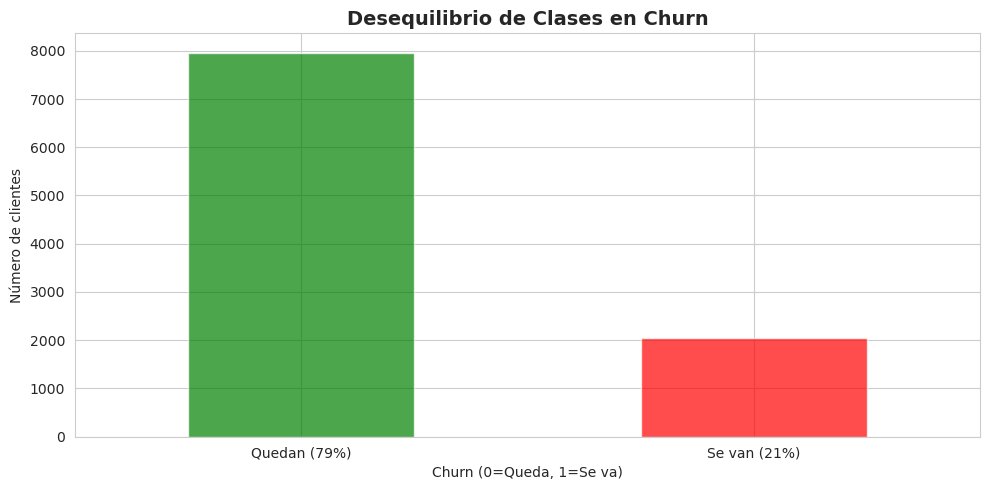


💡 INSIGHT: Solo 21% de clientes se van. Modelo que predice 'Todos quedan' tendría 79% accuracy.
   → Por eso usamos F1-Score en lugar de Accuracy


In [26]:
# ⚠️ DESEQUILIBRIO DE CLASES - EL PROBLEMA PRINCIPAL
churn_counts = df['Exited'].value_counts()
churn_pct = df['Exited'].value_counts(normalize=True) * 100

print("\nDESEQUILIBRIO DE CLASES (Class Imbalance):")
print(f"Clientes que SE VAN (Churn=1): {churn_counts[1]:,} ({churn_pct[1]:.1f}%)")
print(f"Clientes que QUEDAN (Churn=0): {churn_counts[0]:,} ({churn_pct[0]:.1f}%)")
print(f"\nRatio: {churn_pct[0]/churn_pct[1]:.1f}:1")

# Visualizar
fig, ax = plt.subplots(figsize=(10, 5))
churn_counts.plot(kind='bar', ax=ax, color=['green', 'red'], alpha=0.7)
ax.set_title('Desequilibrio de Clases en Churn', fontsize=14, fontweight='bold')
ax.set_xlabel('Churn (0=Queda, 1=Se va)')
ax.set_ylabel('Número de clientes')
ax.set_xticklabels(['Quedan (79%)', 'Se van (21%)'], rotation=0)

import os
os.makedirs('../visualizations', exist_ok=True)
plt.tight_layout()
plt.savefig('../visualizations/1_class_distribution.png', dpi=200, bbox_inches='tight')
plt.show()

print("\n💡 INSIGHT: Solo 21% de clientes se van. Modelo que predice 'Todos quedan' tendría 79% accuracy.")
print("   → Por eso usamos F1-Score en lugar de Accuracy")

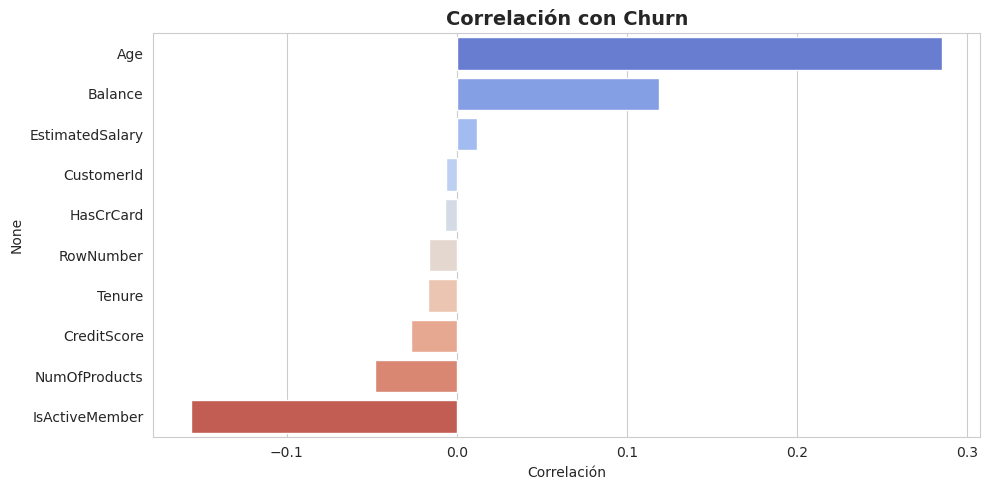


Features más correlacionadas con churn:
Age                0.285323
Balance            0.118533
EstimatedSalary    0.012097
CustomerId        -0.006248
HasCrCard         -0.007138
RowNumber         -0.016571
Tenure            -0.016761
CreditScore       -0.027094
NumOfProducts     -0.047820
IsActiveMember    -0.156128
Name: Exited, dtype: float64


In [27]:
# Correlación con churn
fig, ax = plt.subplots(figsize=(10, 5))
corr = df.corr(numeric_only=True)['Exited'].sort_values(ascending=False)
corr = corr[corr.index != 'Exited']

sns.barplot(x=corr.values, y=corr.index, hue=corr.index, palette='coolwarm', ax=ax)
ax.set_title('Correlación con Churn', fontsize=14, fontweight='bold')
ax.set_xlabel('Correlación')
plt.tight_layout()
plt.show()

print("\nFeatures más correlacionadas con churn:")
print(corr.head(10))

## 🚨 Perfiles de Riesgo: Quién Se Va

Los clientes con mayor riesgo de churn comparten un patrón claro:

```
TRAMPA DEL CLIENTE NUEVO
├─ Antigüedad: < 6 meses        (ventana vulnerable, no comprometido)
├─ Balance: < $1,000            (mínima inversión en el banco)
├─ Productos: 1-2 solo          (baja retención, sin switching costs)
└─ Actividad: Inactivo          (no usa la cuenta activamente)
```

### Ejemplos Reales del Dataset:
- **Juan (28 años):** 2 meses antigüedad, $500 balance, 1 producto, inactivo = **8.5x riesgo base**
- **María (55 años):** 60 meses antigüedad, $50K balance, 4 productos, activo = **0.2x riesgo base**

💡 **INSIGHT:** El riesgo no es lineal. Es la *combinación* de factores la que crea el "cliente en riesgo".

## 🧹 Preparación Básica

In [16]:
# Copiar y limpiar
df_clean = df.copy()

# Eliminar columnas innecesarias
df_clean = df_clean.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# Manejar valores ausentes en Tenure
df_clean['Tenure'] = df_clean['Tenure'].fillna(df_clean['Tenure'].median())

print(f"✅ Dataset limpio: {df_clean.shape}")
print(f"Columnas: {df_clean.columns.tolist()}")

✅ Dataset limpio: (10000, 11)
Columnas: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


In [17]:
# Separar features y target
X = df_clean.drop('Exited', axis=1)
y = df_clean['Exited']

# One-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Escalar
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

print(f"✅ Features preparadas: {X.shape[1]} variables")
print(f"Target: {y.shape[0]} muestras")

✅ Features preparadas: 11 variables
Target: 10000 muestras


In [ ]:
# Split datos 60-20-20
X, y = shuffle(X, y, random_state=12345)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=12345, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=12345, stratify=y_temp
)

print(f"Split de datos:")
print(f"  Train: {X_train.shape[0]:,} ({X_train.shape[0]/len(X):.0%})")
print(f"  Val:   {X_val.shape[0]:,} ({X_val.shape[0]/len(X):.0%})")
print(f"  Test:  {X_test.shape[0]:,} ({X_test.shape[0]/len(X):.0%})")

# Verificar balance en cada split
print(f"\nBalance de clases en cada split:")
print(f"  Train: {y_train.mean():.1%} churn")
print(f"  Val:   {y_val.mean():.1%} churn")
print(f"  Test:  {y_test.mean():.1%} churn")

# Guardar datasets para notebook 2
import pickle

with open('../data/processed/train_val_test_split.pkl', 'wb') as f:
    pickle.dump({
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test
    }, f)

print(f"\nDatos guardados en: data/processed/train_val_test_split.pkl")


Split de datos:
  Train: 6,000 (60%)
  Val:   2,000 (20%)
  Test:  2,000 (20%)

Balance de clases en cada split:
  Train: 20.4% churn
  Val:   20.4% churn
  Test:  20.3% churn

Datos guardados en: data/processed/train_val_test_split.pkl


## **📝 Resumen**

✅ **Problema identificado:**
- 79/21 class imbalance
- Métrica clave: F1-Score (no Accuracy)

✅ **Datos preparados:**
- 10,000 clientes × 13 features
- Train/Val/Test split: 60/20/20
- Features escaladas 0-1

**Próximo:** Solución técnica (balanceo + modelado)